## Import necessary libraries and install that does prebuilt

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### 1. import collab file importer to fetch from local and load the data and perfom some EDA to understand data nature

In [3]:
#google collab file import
from google.colab import files

uploaded = files.upload()

Saving hypertension_data.csv to hypertension_data.csv


In [4]:
df = pd.read_csv('hypertension_data.csv')

In [5]:
df.columns

Index(['age', 'gender', 'systolic_bp', 'diastolic_bp', 'bmi', 'glucose_level',
       'cholesterol', 'smoker', 'alcohol_use', 'physical_activity',
       'med_adherence', 'risk_score'],
      dtype='object')

In [6]:
df = df.rename(columns = {'risk_score': 'hypertension'})

In [7]:
print ("data shape:", df.shape)

data shape: (500, 12)


In [8]:
df.head()

,age,gender,systolic_bp,diastolic_bp,bmi,glucose_level,cholesterol,smoker,alcohol_use,physical_activity,med_adherence,hypertension
0,68,Female,142.511761,102.452282,28.052850,70.000000,300.000000,1,1,1,1,1
1,58,Male,107.568212,71.060017,29.562498,138.892670,208.413120,0,0,0,0,1
2,44,Male,144.701882,73.295475,25.396126,86.531929,221.485869,0,1,1,0,0
3,72,Male,93.749487,94.602847,26.986992,77.609279,195.617258,0,0,0,0,0
4,37,Female,181.839504,91.041524,30.730937,136.563769,210.080560,0,1,1,1,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                500 non-null    int64  
 1   gender             500 non-null    object 
 2   systolic_bp        500 non-null    float64
 3   diastolic_bp       500 non-null    float64
 4   bmi                500 non-null    float64
 5   glucose_level      500 non-null    float64
 6   cholesterol        500 non-null    float64
 7   smoker             500 non-null    int64  
 8   alcohol_use        500 non-null    int64  
 9   physical_activity  500 non-null    int64  
 10  med_adherence      500 non-null    int64  
 11  hypertension       500 non-null    int64  
dtypes: float64(5), int64(6), object(1)
memory usage: 47.0+ KB


In [10]:
df.describe()

,age,systolic_bp,diastolic_bp,bmi,glucose_level,cholesterol,smoker,alcohol_use,physical_activity,med_adherence,hypertension
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,55.406000,136.344891,85.068637,27.285057,113.910136,212.295223,0.286000,0.384000,0.610000,0.664000,0.374000
std,14.608353,20.564706,15.083589,4.969841,27.417424,30.124671,0.452342,0.486845,0.488238,0.472812,0.484348
min,30.000000,90.000000,60.000000,18.000000,70.000000,150.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,123.063407,74.244686,23.760579,93.326526,191.325248,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,136.703554,84.716601,27.063959,114.261068,212.789062,0.000000,0.000000,1.000000,1.000000,0.000000
75%,68.000000,149.979220,96.020033,30.885170,131.251351,231.835565,1.000000,1.000000,1.000000,1.000000,1.000000
max,80.000000,198.488843,120.000000,40.000000,197.700669,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df.isnull().sum()

,0
age,0
gender,0
systolic_bp,0
diastolic_bp,0
bmi,0
glucose_level,0
cholesterol,0
smoker,0
alcohol_use,0
physical_activity,0


In [12]:
df.dtypes

,0
age,int64
gender,object
systolic_bp,float64
diastolic_bp,float64
bmi,float64
glucose_level,float64
cholesterol,float64
smoker,int64
alcohol_use,int64
physical_activity,int64


In [13]:
df["hypertension"].value_counts()

,count
hypertension,
0,313
1,187


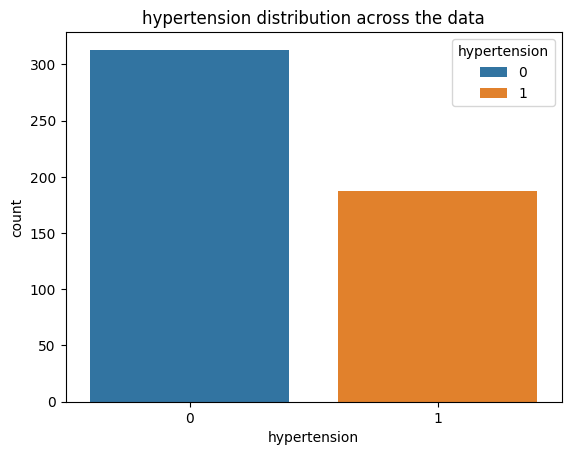

In [14]:
sns.countplot(data = df, x= 'hypertension', hue = 'hypertension')
plt.title('hypertension distribution across the data')
plt.show()

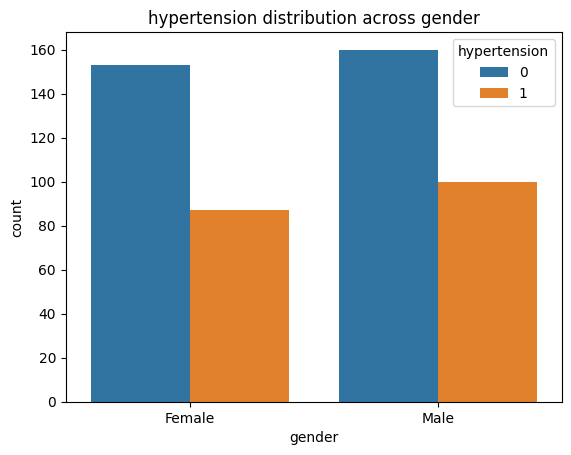

In [16]:
sns.countplot(data = df, x= 'gender', hue = 'hypertension')
plt.title('hypertension distribution across gender')
plt.show()

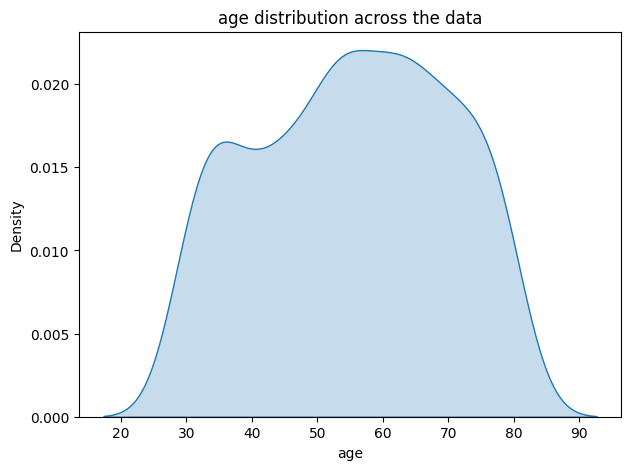

In [17]:
plt.figure(figsize=(7, 5))
sns.kdeplot(data=df, x='age', fill=True)
plt.title('age distribution across the data')
plt.show()

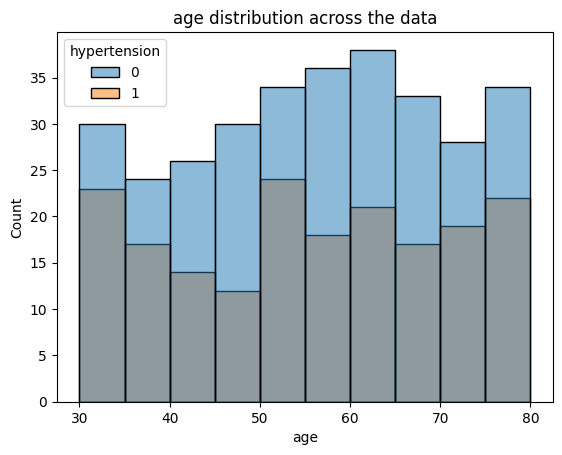

In [18]:
sns.histplot(data = df, x= 'age',
            hue = 'hypertension')
plt.title('age distribution across the data')
plt.show()

### # lets check for outliers if any using boxplot for only continous features

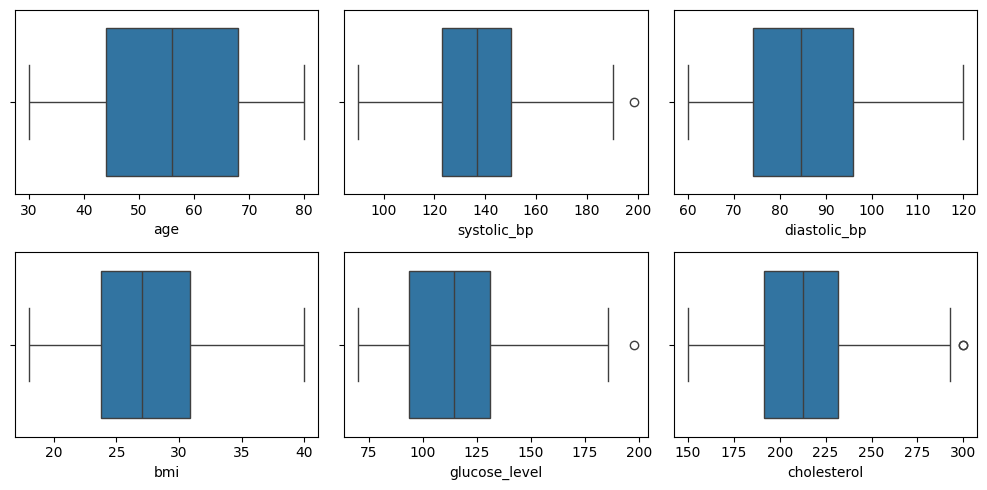

In [19]:
num_vars = ['age', 'systolic_bp', 'diastolic_bp', 'bmi', 'glucose_level', 'cholesterol' ]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))
axs = axs.flatten()

for i, var in enumerate(num_vars):
    sns.boxplot(x=var, data=df, ax=axs[i])

fig.tight_layout()

plt.show()

In [ ]:
# feature_columns = df.columsn[:-1]
# feature_target = df.columns[: -1]
# X = df[feature_columns]
# y = df[feature_target]

### 2. Preprocessing

In [20]:
X = df.drop ('hypertension', axis = 1)
y  = df['hypertension']

In [21]:
# Apply Label Encoding to categorical columns ('gender')
from sklearn.preprocessing import LabelEncoder
# Check for object/string columns which might need encoding
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le # Save encoder for potential use later


In [22]:
X_encoded.head()

,age,gender,systolic_bp,diastolic_bp,bmi,glucose_level,cholesterol,smoker,alcohol_use,physical_activity,med_adherence
0,68,0,142.511761,102.452282,28.052850,70.000000,300.000000,1,1,1,1
1,58,1,107.568212,71.060017,29.562498,138.892670,208.413120,0,0,0,0
2,44,1,144.701882,73.295475,25.396126,86.531929,221.485869,0,1,1,0
3,72,1,93.749487,94.602847,26.986992,77.609279,195.617258,0,0,0,0
4,37,0,181.839504,91.041524,30.730937,136.563769,210.080560,0,1,1,1


### 3. data split

In [23]:
# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

In [24]:
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 400
Test set size: 100


### # Train the data before hyperparameter optimization

In [25]:
from sklearn.ensemble import RandomForestClassifier

# build random forest classifier
RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train, y_train)

# make predictions on test set
y_preds = RF.predict(X_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_preds)

# Printing the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.86


In [26]:
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_preds = xgb_model.predict(X_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_preds)

# Printing the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.94


### 4. Optuna hyperparameter tuning

In [27]:
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'use_label_encoder': False
    }

    X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    model = xgb.XGBClassifier(**param)
    model.fit(
        X_train_opt, y_train_opt,
        eval_set=[(X_val_opt, y_val_opt)],
        verbose=False
    )

    preds = model.predict_proba(X_val_opt)[:, 1]
    auc_score = roc_auc_score(y_val_opt, preds)
    return auc_score

In [28]:
# Create and run the Optuna study
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=50) # Reduced trials for demonstration; increase if needed

print("\nBest trial:")
print(study.best_trial)
print("Best parameters:", study.best_params)

[I 2025-08-08 06:42:10,191] A new study created in memory with name: no-name-347deeed-ec23-47d0-8839-21d7051304e8
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:42:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-08-08 06:42:21,729] Trial 0 finished with value: 1.0 and parameters: {'max_depth': 6, 'learning_rate': 0.28570714885887566, 'n_estimators': 759, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 1.5599452033620265, 'reg_alpha': 0.2904180608409973, 'reg_lambda': 4.330880728874676}. Best is trial 0 with value: 1.0.
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [06:42:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-08-08 06:42:22,484] Trial 1 finished with value: 0.994 and parameters: {'


Best trial:
FrozenTrial(number=0, state=1, values=[1.0], datetime_start=datetime.datetime(2025, 8, 8, 6, 42, 10, 197716), datetime_complete=datetime.datetime(2025, 8, 8, 6, 42, 21, 729263), params={'max_depth': 6, 'learning_rate': 0.28570714885887566, 'n_estimators': 759, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 1.5599452033620265, 'reg_alpha': 0.2904180608409973, 'reg_lambda': 4.330880728874676}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'gamma': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'reg_alpha': FloatDistribution(high=5.0, log=Fal

### # Train the data after hyperparameter optimization
#### 5. Model Training with Best Parameters

In [29]:
# 5. Model Training with Best Parameters
best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5780093202212182, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=1.5599452033620265, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.28570714885887566,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=759, n_jobs=None,
              num_parallel_tree=None, ...)

### 6. Model Evaluation

In [30]:
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

In [31]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("\n--- Model Evaluation Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")


--- Model Evaluation Metrics ---
Accuracy: 0.9900
F1 Score: 0.9863
AUC-ROC: 1.0000


In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)


Confusion Matrix:
[[63  0]
 [ 1 36]]


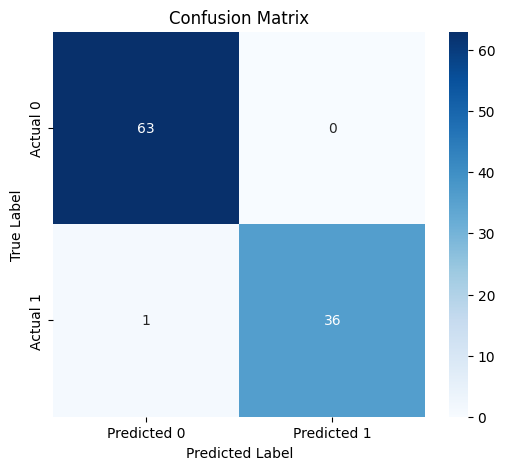

In [33]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [34]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        63
           1       1.00      0.97      0.99        37

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



### 7. SHAP Explanation

In [35]:
# Create SHAP explainer
explainer = shap.TreeExplainer(final_model)

In [36]:
# Calculate SHAP values for the test set (or a sample for faster computation)
shap_values = explainer.shap_values(X_test)

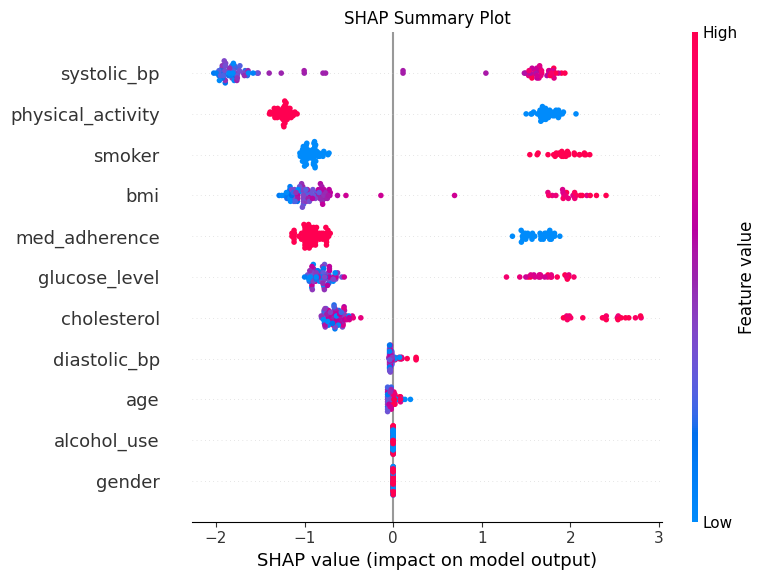

In [37]:
# Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, feature_names=X_encoded.columns, show=False)
plt.title('SHAP Summary Plot')
plt.tight_layout()
plt.show()

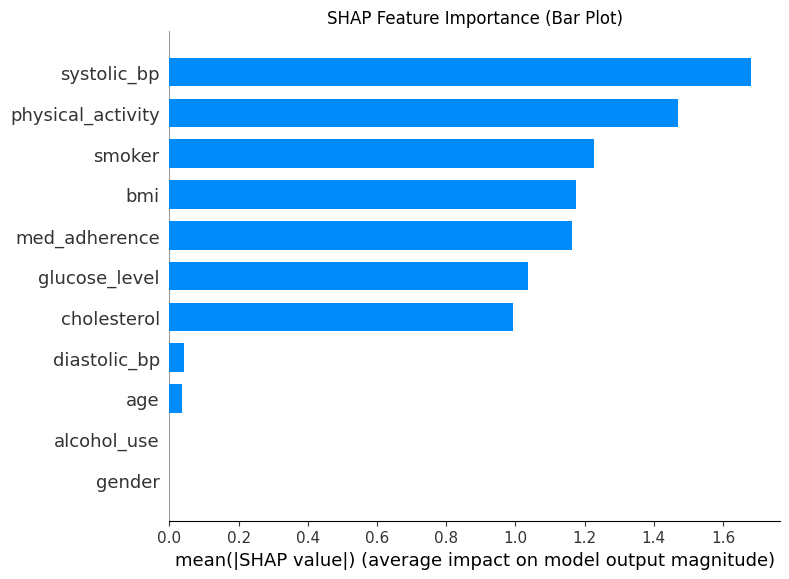

In [38]:
# Bar Plot of Mean Absolute SHAP Values
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_encoded.columns, show=False)
plt.title('SHAP Feature Importance (Bar Plot)')
plt.tight_layout()
plt.show()

### 8. Save the trained model

In [39]:
model_filename = 'model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(final_model, file)

print(f"\nModel saved to {model_filename}")


if label_encoders:
    encoders_filename = 'label_encoders.pkl'
    with open(encoders_filename, 'wb') as file:
        pickle.dump(label_encoders, file)
    print(f"Label encoders saved to {encoders_filename}")



Model saved to model.pkl
Label encoders saved to label_encoders.pkl


In [ ]:
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('label_encoders.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
import os
print("Model saved:", os.path.exists("model.pkl"))


Model saved: True
